# Gastruloid composition analysis vs embryo dissections

In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.decomposition
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from custom_functions import *

save_format='svg'

In [171]:
#time='E8.5'
time='E8.75'

#### Gastruloid data

In [172]:
df_gastruloid = pd.read_csv("data/chir_act_counts.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)
df_gastruloid_metadata = pd.read_csv("data/metadata_chir_new.csv",index_col=0)

#Retain only samples of interest
if time=='E8.5':
    df_gastruloid = df_gastruloid.loc[[(("CHIR" in i) and ("120h" in i)) or (("ActA" in i) and ("144h" in i)) for i in df_gastruloid.index.values]]
    df_gastruloid_metadata = df_gastruloid_metadata.loc[[(("CHIR" in i) and ("120h" in i)) or (("ActA" in i) and ("144h" in i)) for i in df_gastruloid_metadata.index.values]]
elif time=='E8.75':
    df_gastruloid = df_gastruloid.loc[[(("ActA" in i) and ("144h" in i)) for i in df_gastruloid.index.values]]
    df_gastruloid_metadata = df_gastruloid_metadata.loc[[(("ActA" in i) and ("144h" in i)) for i in df_gastruloid_metadata.index.values]]

#### Embryo data

In [173]:
adata_embryo = sc.read_h5ad(f'data/pijuan_sala_sections.h5ad')
adata_embryo = adata_embryo[:,~adata_embryo.var['mgi_symbol'].duplicated(keep=False)]

if time=='E8.75': # keep only anterior and medial section for E8.75
    adata_embryo=adata_embryo[adata_embryo.obs.anatomy.isin(['Anterior section','Medial section'])]

In [174]:
# Consistent datasets
common_genes=np.intersect1d(df_gastruloid.columns.values, adata_embryo.var['mgi_symbol'])

adata_embryo=adata_embryo[:,adata_embryo.var['mgi_symbol'].isin(common_genes)]
df_gastruloid=df_gastruloid.loc[:,common_genes]
df_gastruloid = df_gastruloid.reindex(columns=adata_embryo.var['mgi_symbol'].values)


### Define embryo populations

In [175]:
# list with every section subset
pops = {}
for a in adata_embryo[adata_embryo.obs.stage.isin([time])].obs.anatomy.unique():
    a_=adata_embryo[(adata_embryo.obs.stage.isin([time]))&(adata_embryo.obs.anatomy.isin([a]))]
    pops[a]=a_
pops={key:value for key, value in sorted(pops.items())} # sort dict as anterior, (medial), posterior 

## Analysis

### Constructing mixed populations of Anterior-(Medial)-Posterior
Creating subbatches, pseudoreplicates

In [176]:
# creating splits / subbatches
def kFold_split(adata, n_splits:int=None):
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the indices for splitting
    indices = np.arange(adata.n_obs)
    folds = list(kf.split(indices))

    train_sets = []
    test_sets = []

    for train_index, test_index in folds:
        # Create training and test AnnData objects
        train_data = adata[train_index].copy()
        test_data = adata[test_index].copy()
        
        train_sets.append(train_data)
        test_sets.append(test_data)
        
    return test_sets


**Number of splits:** 5

In [177]:
n_splits=5

In [178]:
pop_sets={}
for s, v in pops.items():
    pop_sets[s]=kFold_split(v, n_splits=n_splits)

Constructing computational mixed population from adata subsets (5% steps)

In [179]:
# defining proportions
proportions = np.arange(1.0,-0.05,-0.05)

In [180]:
data = []
labels=[]

for split in range(n_splits):
    for proportion in proportions:
        # creating mixed pop according to proportions
        mx = create_mixed_populations(pop_sets, proportion, i1=np.random.randint(0, n_splits),i2=np.random.randint(0, n_splits))
        mx_pb = np.array(mx.X.sum(axis=0)).flatten()
        data.append(mx_pb)
        # row label
        if time=='E8.5':
            key = f'A-P_{proportion*100:.0f}%-{(1-proportion)*100:.0f}%_s{split}'
            labels.append(key)

        elif time=='E8.75':
            # row label
            key = f'A-M_{proportion*100:.0f}%-{(1-proportion)*100:.0f}%_s{split}'
            labels.append(key)


mixed_populations = pd.DataFrame(data, index=labels, columns=df_gastruloid.columns.values)

In [181]:
# sort conditions
def sort_key(s):
    parts = s.split('_')
    # sort conditions and 100-0% to 0-100%
    return (parts[0], -int(parts[1].split('%')[0]))

# Sort the list using the sort_key
sorted_strings = sorted(mixed_populations.index, key=sort_key)
df_pops=mixed_populations.reindex(sorted_strings, axis=0)

# filter df
if time=='E8.5':
    # renaming biological conditions
    df_pops.index=df_pops.index.str.replace(f'A-P_100%-0%','Anterior')
    df_pops.index=df_pops.index.str.replace(f'A-P_-0%-100%', 'Posterior')
else:
    # renaming biological conditions
    df_pops.index=df_pops.index.str.replace(f'A-M_100%-0%','Anterior')
    df_pops.index=df_pops.index.str.replace(f'A-M_-0%-100%','Medial')
    


### Scaling

In [182]:
df1 = df_gastruloid.copy()
df1 = df1.div(df1.sum(axis=1), axis=0)*10E6
df1 = np.log1p(df1)
df1.fillna(0,inplace=True)

In [183]:
df2= df_pops.copy()
df2 = df2.div(df2.sum(axis=1), axis=0)*10E6
df2 = np.log1p(df2)
df2.fillna(0,inplace=True)

### Feature selection

In [184]:
fs = VarianceThreshold(threshold=0.287)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

hvg='g_hvg'
#hvg='e_hvg'

len(l)

1000

In [185]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index)
df2_fs = pd.DataFrame(fs.transform(df2.values),index=df2.index)

### PCA

<Axes: >

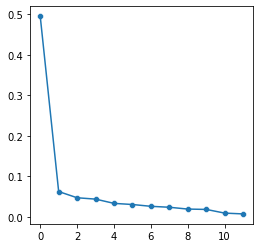

In [186]:
pca = PCA(n_components=12)
pca.fit(df2_fs)

fig,ax=plt.subplots(1,1, figsize=(4,4))

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_, ax=ax)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_,ax=ax)

## Scatterplot

In [187]:
df_gastruloid_metadata['Condition'][:3]

Sample
144h-low-ActA_1    144h-low-ActA
144h-low-ActA_2    144h-low-ActA
144h-low-ActA_3    144h-low-ActA
Name: Condition, dtype: object

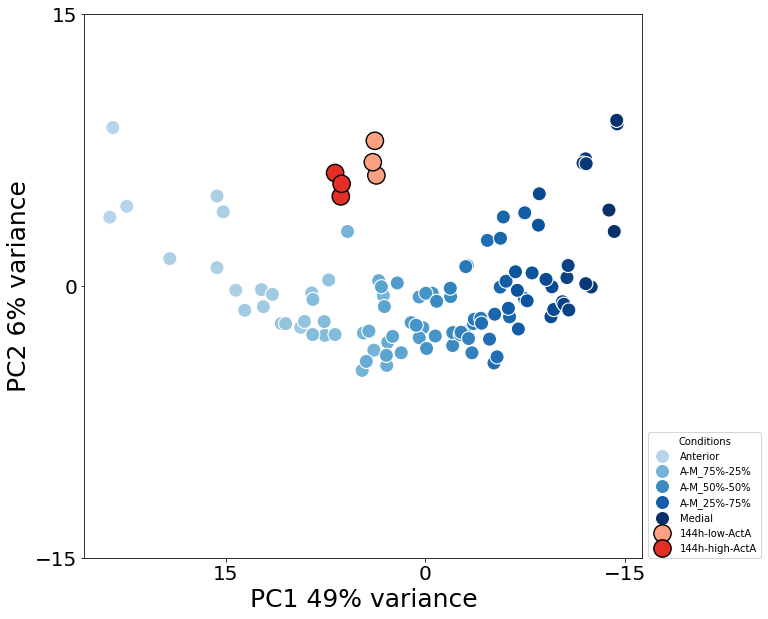

In [191]:
fig,ax = plt.subplots(figsize=(10,10))

# design palette (darker blues for visible  dots)
palette = [plt.get_cmap('Blues')(value) for value in np.linspace(0.3,1,len(proportions))]
# emrbyo
x = pca.transform(fs.transform(df2.values))
df_embryo_ = pd.DataFrame(x,index=df2.index.values)
p2 = sns.scatterplot(x=df_embryo_.values[:,0],y=df_embryo_.values[:,1],
                     hue=[i.split('_s')[0] for i in df_embryo_.index.values],marker="o",palette=palette,s=200)
# gastruloid
x = pca.transform(fs.transform(df1.values))
if time=='E8.5':
    p = sns.scatterplot(x=x[:3,0],y=x[:3,1],
                    hue=df_gastruloid_metadata["Condition"][:3],
                    s=300,palette="Greens", edgecolor='black')
    p = sns.scatterplot(x=x[3:,0],y=x[3:,1],
                    hue=df_gastruloid_metadata["Condition"][3:],
                    s=300,palette="Reds", edgecolor='black')
if time=='E8.75':
    p = sns.scatterplot(x=x[:,0],y=x[:,1],
                hue=df_gastruloid_metadata["Condition"],
                s=300,palette="Reds", edgecolor='black')

# axes
plt.xlabel(f'PC1 {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=25)
plt.ylabel(f'PC2 {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=25)

#
ax.set_xticks([-15,0, 15])
plt.xticks(fontsize=20)
ax.set_yticks([-15,0, 15])
plt.yticks(fontsize=20)

if time=='E8.5':
    ls=['120h-3μM-CHIR','144h-low-ActA','144h-high-ActA', 'Anterior', 'A-P_25%-75%','A-P_50%-50%','A-P_75%-25%', 'Posterior']
elif time=='E8.75':
    ls=['144h-low-ActA','144h-high-ActA', 'Anterior', 'A-M_25%-75%','A-M_50%-50%','A-M_75%-25%', 'Medial']

# Filter handles and labels by string match
handles,labels=ax.get_legend_handles_labels()
selected_handles = [h for h, l in zip(handles, labels) if l in ls]
selected_labels = [l for l in labels if l in ls]

#legend
ax.legend(handles=selected_handles, labels=selected_labels,loc=(1.01,0),title="Conditions")
ax.invert_xaxis()
#plt.savefig(f"results/spatial_composition_analysis_scatterplot_{hvg}_{time}.{save_format}",bbox_inches="tight",transparent=True)

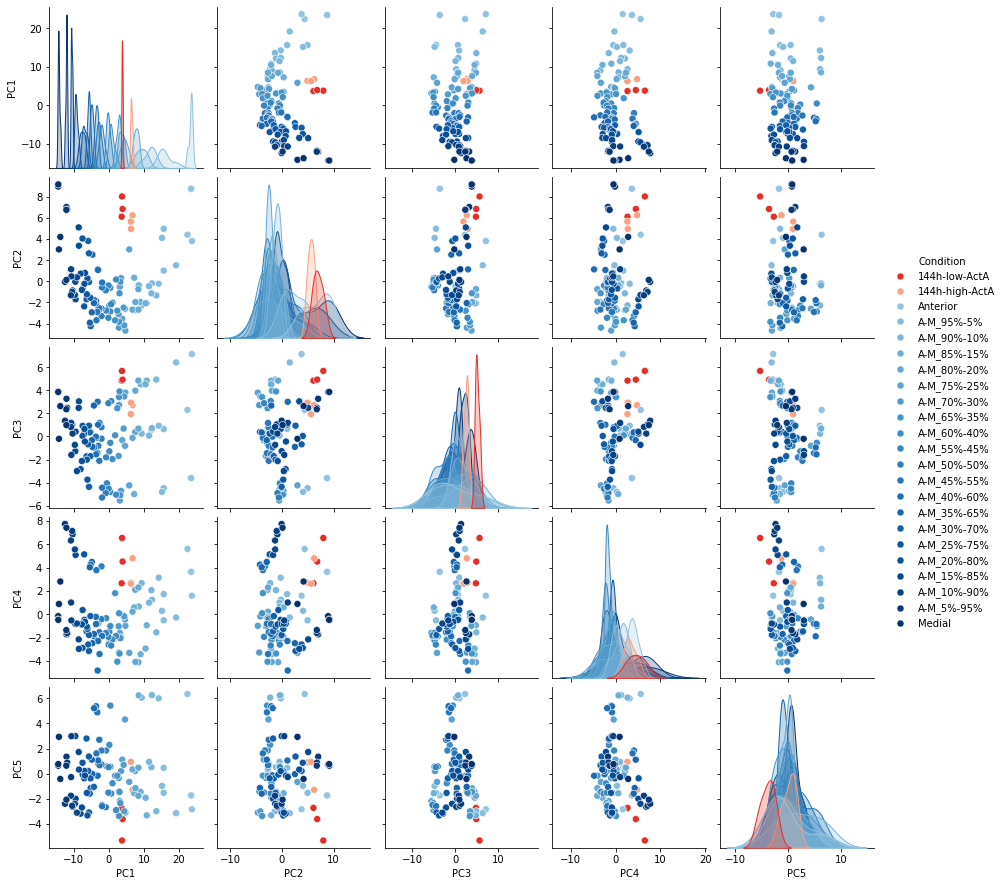

In [189]:
# Define the number of PCA components you want to visualize
num_pca_components = 5 

# Create a DataFrame with PCA components for df1
x1 = pca.transform(fs.transform(df1.values))
df1_pca = pd.DataFrame(x1[:, :num_pca_components], columns=[f'PC{i+1}' for i in range(num_pca_components)])
df1_pca['Condition'] = df_gastruloid_metadata["Condition"].values
df1_pca['Dataset'] = 'df1'  # Label the dataset for conditional coloring

# Create a DataFrame with PCA components for df2
x2 = pca.transform(fs.transform(df2.values))
df2_pca = pd.DataFrame(x2[:, :num_pca_components], columns=[f'PC{i+1}' for i in range(num_pca_components)])
df2_pca['Condition'] = [i[:-3] for i in df2.index.values]  # Adjust if necessary
df2_pca['Dataset'] = 'df2'  # Label the dataset for conditional coloring

# Combine both DataFrames
df_combined = pd.concat([df1_pca, df2_pca]).reset_index(drop=True)

# Create custom palettes: Reds for df1 conditions, Blues for df2 conditions
df1_palette = sns.color_palette("Reds_r", len(df1_pca.Condition.unique()))  # One color per condition in df1
df2_palette = [plt.get_cmap('Blues')(value) for value in np.linspace(0.4,1,len(df2_pca.Condition.unique()))]  # One color per condition in df2

# Create a combined color palette mapping each condition to its respective color
combined_palette = {cond: color for cond, color in zip(df1_pca.Condition.unique(), df1_palette)}
combined_palette.update({cond: color for cond, color in zip(df2_pca.Condition.unique(), df2_palette)})

# Create a pairplot
g = sns.pairplot(df_combined, vars=[f'PC{i+1}' for i in range(num_pca_components)], hue='Condition', palette=combined_palette, plot_kws={'s': 50})

if time=='E8.5':
    ls=['120h-3μM-CHIR','144h-low-ActA','144h-high-ActA', 'Anterior', 'A-P_25%-75%','A-P_50%-50%','A-P_75%-25%' 'Posterior']
elif (time=='E8.75') or (time=='E9.0'):
    ls = ['144h-low-ActA','144h-high-ActA', 'Anterior', 'A-M_50%-50%','Medial','M-P_50%-50%', 'Posterior']
# Filter handles and labels by string match
handles,labels=ax.get_legend_handles_labels()
selected_handles = [h for h, l in zip(handles, labels) if l in ls]
selected_labels = [l for l in labels if l in ls]

#legend
ax.legend(handles=selected_handles, labels=selected_labels,loc=(1.01,0),title="Conditions")

# Save the pairplot
plt.savefig(f"results/pairplot_pca_combined_{hvg}_{time}.{save_format}", bbox_inches="tight", transparent=True)

plt.show()


## Distance

In [132]:
metric='euclidean'
d_euclidean,m_euclidean = distance_table(df1_fs,df2_fs,metric=metric)

In [133]:
order = pd.DataFrame([x[:-3] for x in df2.index.values]).drop_duplicates(subset=0).iloc[:,0].values.tolist()

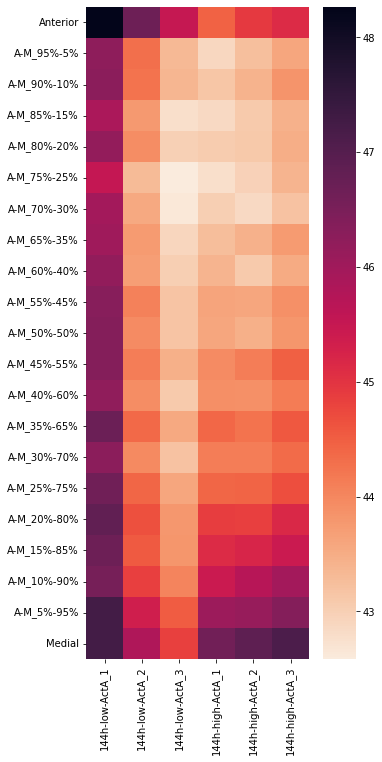

In [134]:
fig, ax = plt.subplots(1,1,figsize=(5,12))
#d_euclidean_ = d_euclidean.groupby([i[:-2] for i in d_euclidean.index.values]).mean()
d_euclidean_ = d_euclidean.groupby(d_euclidean.columns.str.replace(r'_s\d+', '', regex=True), axis=1).mean().T
sns.heatmap(d_euclidean_.loc[order], cmap="rocket_r", ax=ax)

plt.savefig(f'results/{metric}_distance_AP_composition_{time}.{save_format}')

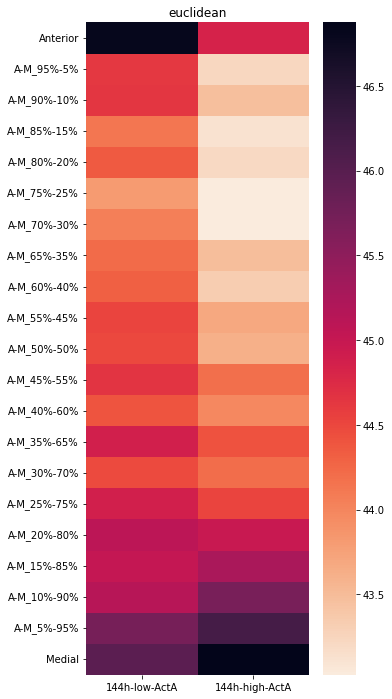

In [135]:
fig, ax = plt.subplots(1,1,figsize=(5,12))
d_euclidean_ = d_euclidean.groupby([i[:-2] for i in d_euclidean.index.values]).mean()
d_euclidean_ = d_euclidean_.groupby(d_euclidean_.columns.str.replace(r'_s\d+', '', regex=True), axis=1).mean().T

if time=='E8.5':
    sns.heatmap(d_euclidean_.loc[order,['120h-3μM-CHIR','144h-low-ActA','144h-high-ActA']], cmap="rocket_r", ax=ax)
else:
    sns.heatmap(d_euclidean_.loc[order,['144h-low-ActA','144h-high-ActA']], cmap="rocket_r", ax=ax)
ax.set_title(metric);

plt.savefig(f"results/{metric}_distance_AP_composition_{time}_mean.{save_format}",bbox_inches="tight",transparent=True)

## Distance to embryo sections

In [142]:
df2=df2.loc[[x for x in df2.index.values if ('Anterior' in x[:-3]) or ('Medial' in x[:-3])],:]
df2

,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.3,AC125149.5,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,Vmn2r122,CAAA01147332.1
